In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.data.utils import ngrams_iterator
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter
import torch.optim as optim
from collections import Counter
from tqdm.notebook import tqdm
import os
from utils.get_embeddings import *

In [2]:
df = load_df(os.path.join('data', 'train_spam.csv'))
df

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [3]:
enc_dict = {x: y for y, x in enumerate(df['text_type'].unique())}
dec_dict = {y: x for y, x in enumerate(df['text_type'].unique())}

In [4]:
df['text_type'] = df['text_type'].map(enc_dict)

In [5]:
df

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...
...,...,...
16273,1,if you are interested in binary options tradin...
16274,1,dirty pictureblyk on aircel thanks you for bei...
16275,0,or you could do this g on mon 1635465 sep 1635...
16276,0,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [6]:
length = df['text'].apply(lambda x: len(x))

In [7]:
length.max()

800

In [8]:
df.isna().sum()

text_type    0
text         0
dtype: int64

In [9]:
tokenizer = get_tokenizer("basic_english")

In [10]:
def gen_rows(df):
    for row in df.itertuples(index=False):
        yield row[0], row[1]
df_iter = gen_rows(df)

In [11]:
def yield_tokens(data_iter): 
    for _, text in data_iter: 
        yield tokenizer(text) 

In [12]:
def get_vocab(train_datapipe): 
  vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), 
                                    specials=['<unk>', '<sos>', '<pad>', '<eos>'],
                                    special_first=True, max_tokens=250_000
                                    ) 
  vocab.set_default_index(vocab['<unk>'])
  return vocab

In [13]:
idx = np.arange(len(df))

In [14]:
df_train, df_test, idx_train, idx_test = train_test_split(df, idx, test_size=0.25)

In [15]:
train_iter = gen_rows(df_train)
test_iter = gen_rows(df_test)

In [16]:
vocab = get_vocab(train_iter)

In [17]:
len(vocab)

48035

In [18]:
text_transform = lambda x: vocab(tokenizer(x))
label_transform = lambda x: int(x)

In [19]:
c = Counter(df_train['text_type'].values)
count = {k: 100/v for k, v in c.items()}
squarer = lambda x: count[x]
vfunc = np.vectorize(squarer)
weights = vfunc(df_train['text_type'].values) #len(df_train)
sampler = WeightedRandomSampler(weights, len(df_train), replacement=True)

In [20]:
def collate_batch(batch):
    global device
    label_list, text_list, text_len = [], [], []
    
    for (_label, _text) in batch:
        processed_text = torch.tensor(text_transform(_text), dtype=torch.int64)
        if len(processed_text) > 0:
            label_list.append(_label)
            text_list.append(processed_text)
            text_len.append(processed_text.size(0))
    
    label_list = torch.tensor(label_list, dtype=torch.int64).to(device)
    text_len = torch.tensor(text_len, dtype=torch.int64).to(device)
    return label_list, pad_sequence(text_list, batch_first=True).to(device), text_len

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
df_train_list = df_train.values.tolist()
df_test_list = df_test.values.tolist()

In [23]:
train_dataloader = DataLoader(df_train_list, batch_size=32, collate_fn=collate_batch, shuffle=True)
test_dataloader = DataLoader(df_test_list, batch_size=32, collate_fn=collate_batch)

In [24]:
import torch.nn as nn

class LSTMNet(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first=True
                           )
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self,text,text_lengths):

        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),
                                                            enforce_sorted=False, batch_first=True)
        
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        dense_outputs=self.fc(hidden)
        
        return dense_outputs

In [25]:
def train(model, iterator, opt, criterion):
    epoch_loss = 0.0
    epoch_auc = 0.0
    
    model.train()
    
    for batch in iterator:
        
        opt.zero_grad()
        
        text_labels, text, text_lengths = batch

        predictions = model(text, text_lengths).squeeze()
        loss = criterion(predictions.float(), text_labels.float())
        loss.backward()
        # Нужно для того, чтобы не вылезла ошибка
        # ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
        # Зависит от разбиения
        try:
            auc = roc_auc_score(text_labels.cpu().numpy(), predictions.detach().cpu().numpy())
            epoch_auc += auc.item()
        except:
            pass
        
        opt.step()
        
        epoch_loss += loss.item()
        

    return epoch_loss / len(iterator), epoch_auc / len(iterator)

def evaluate(model,iterator,criterion):

    epoch_loss = 0.0
    epoch_auc = 0.0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            
            text_labels, text, text_lengths = batch
            
            predictions = model(text,text_lengths).squeeze()

            loss = criterion(predictions.float(), text_labels.float())
            epoch_loss += loss.item()
            # Нужно для того, чтобы не вылезла ошибка
            # ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
            # Зависит от разбиения
            try:
                auc = roc_auc_score(text_labels.cpu().numpy(), predictions.detach().cpu().numpy())
                epoch_auc += auc.item()
            except:
                pass
        
    return epoch_loss / len(iterator), epoch_auc / len(iterator)

In [26]:
SIZE_OF_VOCAB = len(vocab)
EMBEDDING_DIM = 512
NUM_HIDDEN_NODES = 256
NUM_OUTPUT_NODES = 1
NUM_LAYERS = 2
BIDIRECTION = True
DROPOUT = 0.35

In [27]:
model = LSTMNet(SIZE_OF_VOCAB,
                EMBEDDING_DIM,
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
                BIDIRECTION,
                DROPOUT
               )

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
LR = 5e-3
opt = optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(opt, 'min', verbose=True, threshold=0.01, patience=2)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [29]:
EPOCH_NUMBER = 10
best_auc = 0
loss = {'train': [], 'test': []}
auc = {'train': [], 'test': []}
try:
    for epoch in tqdm(range(1, EPOCH_NUMBER + 1)):
        train_loss, train_auc = train(model, train_dataloader, opt, criterion)
        
        valid_loss, valid_auc = evaluate(model, test_dataloader, criterion)

        loss['train'].append(train_loss)
        loss['test'].append(valid_loss)

        auc['train'].append(train_auc)
        auc['test'].append(valid_auc)

        if best_auc <= valid_auc:
            best_auc = valid_auc
            torch.save(model.state_dict(), os.path.join('models', 'best_model_lstm.pt'))

        scheduler.step(valid_loss)
        print(f'\tTrain Loss: {train_loss:.5f} | Train Auc: {train_auc*100:.5f}%')

        print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Auc: {valid_auc*100:.5f}%')
        print()

except KeyboardInterrupt:
    print(f'Training stopped on epoch: {epoch}')

  0%|          | 0/10 [00:00<?, ?it/s]

	Train Loss: 0.24361 | Train Auc: 94.84494%
	 Val. Loss: 0.20307 |  Val. Auc: 98.65377%

	Train Loss: 0.05170 | Train Auc: 99.78559%
	 Val. Loss: 0.15804 |  Val. Auc: 98.71265%

	Train Loss: 0.01288 | Train Auc: 99.98316%
	 Val. Loss: 0.15641 |  Val. Auc: 98.74498%

	Train Loss: 0.00720 | Train Auc: 99.99783%
	 Val. Loss: 0.23374 |  Val. Auc: 98.72779%

	Train Loss: 0.00289 | Train Auc: 100.00000%
	 Val. Loss: 0.23532 |  Val. Auc: 98.53620%

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
	Train Loss: 0.00456 | Train Auc: 99.99850%
	 Val. Loss: 0.23935 |  Val. Auc: 98.65588%

	Train Loss: 0.00247 | Train Auc: 99.99894%
	 Val. Loss: 0.22868 |  Val. Auc: 98.69571%

	Train Loss: 0.00025 | Train Auc: 100.00000%
	 Val. Loss: 0.23535 |  Val. Auc: 98.69216%

Epoch 00009: reducing learning rate of group 0 to 5.0000e-05.
	Train Loss: 0.00016 | Train Auc: 100.00000%
	 Val. Loss: 0.23904 |  Val. Auc: 98.69226%

	Train Loss: 0.00010 | Train Auc: 100.00000%
	 Val. Loss: 0.23944 |  Val

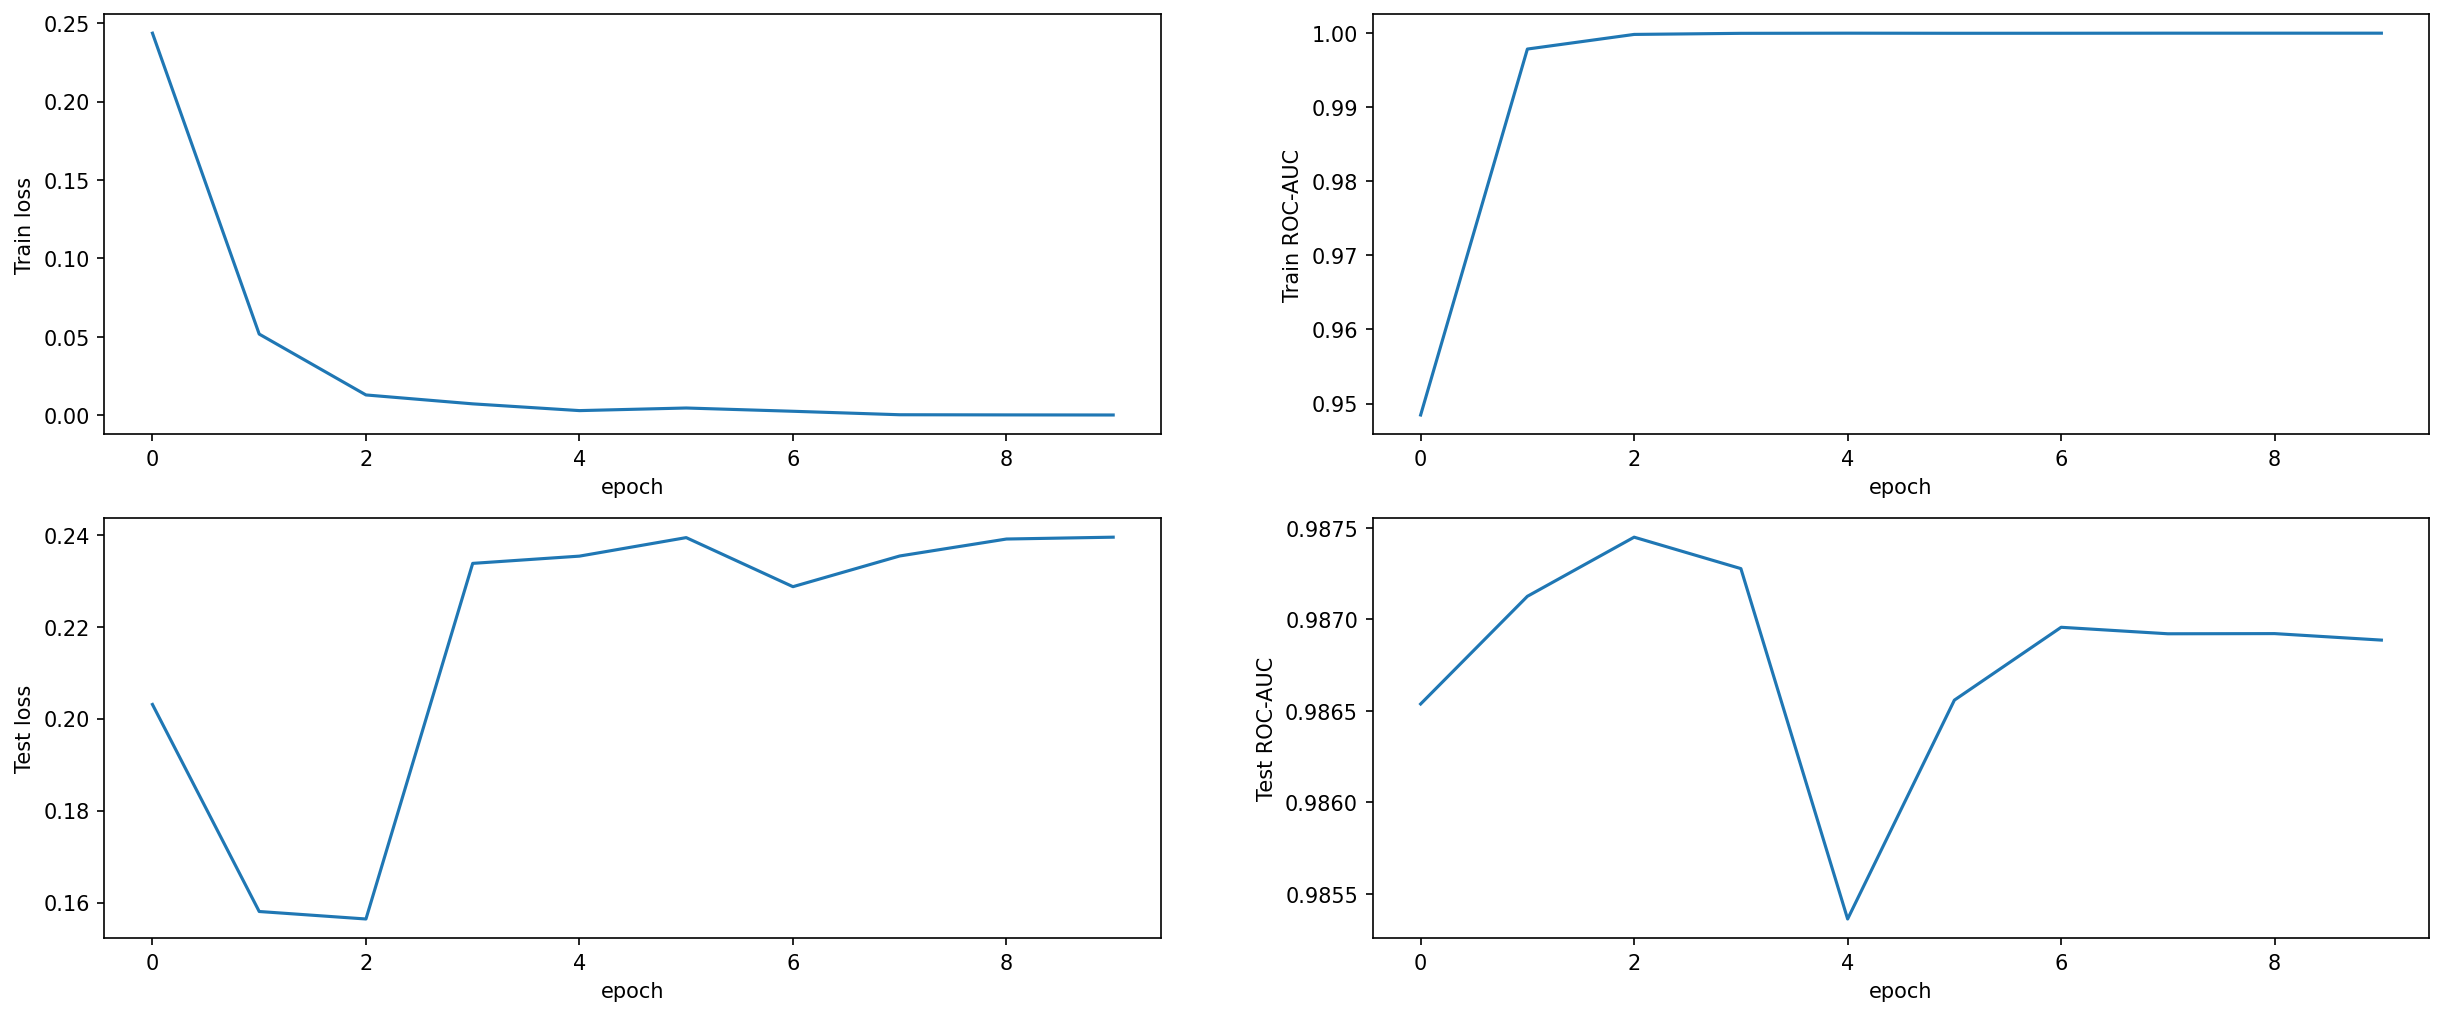

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(20, 8), dpi=150)
ax[0, 0].plot(loss['train'])
ax[0, 0].set_xlabel('epoch')
ax[0, 0].set_ylabel('Train loss')

ax[0, 1].plot(auc['train'])
ax[0, 1].set_xlabel('epoch')
ax[0, 1].set_ylabel('Train ROC-AUC')

ax[1, 0].plot(loss['test'])
ax[1, 0].set_xlabel('epoch')
ax[1, 0].set_ylabel('Test loss')

ax[1, 1].plot(auc['test'])
ax[1, 1].set_xlabel('epoch')
ax[1, 1].set_ylabel('Test ROC-AUC')
None

In [31]:
def predict(model, iterator):
    global device
    model.eval()
    model.to(device)
    probabilities = []
    with torch.no_grad():
        for batch in iterator:
            
            text_labels, text, text_lengths = batch
            
            predictions = model(text,text_lengths).squeeze()
            probabilities.append(torch.sigmoid(predictions))

    return torch.cat(probabilities)

In [32]:
best_model = model = LSTMNet(SIZE_OF_VOCAB,
                             EMBEDDING_DIM,
                             NUM_HIDDEN_NODES,
                             NUM_OUTPUT_NODES,
                             NUM_LAYERS,
                             BIDIRECTION,
                             DROPOUT
                            )
best_model.load_state_dict(torch.load(os.path.join('models', 'best_model_lstm.pt')))

<All keys matched successfully>

In [33]:
p = predict(best_model, test_dataloader).cpu().numpy()

In [34]:
pred_labels = (p > 0.5).astype(int)

In [35]:
pred_labels.shape

(4070,)

In [36]:
test_labels = []
for el in df_test_list:
    test_labels.append(el[0])
test_labels = np.array(test_labels)

In [37]:
(test_labels != pred_labels).sum()

177

Посмотрим, на каких примерах модель ошибается (1 - спам, 0 - не спам)

In [38]:
df.loc[idx_test[test_labels != pred_labels]]

,text_type,text
14850,1,it s just too small hloy a man endowed with a ...
6605,0,only 1 week left to register for the henwood p...
4277,0,btc down whole market down
4392,0,from todays sun url your vote on crop idol by ...
3937,0,ive got nothing smart to say excepthappy new y...
...,...,...
1785,0,abeg make profit but its a start are you using...
5095,0,buy one egg for me daplease
2540,1,anyone sell free fire diamonds?
8286,0,eol wti historical trade simulation more profi...
